In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import shutil

Segmentation Models: using `tf.keras` framework.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
height = 512

In [5]:
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_6/Sigmoid:0', description="created by layer 'conv2d_transpose_6'")


In [6]:
val_transforms = albu.Compose([
    albu.Resize(height, height),  # Ensuring your input is always of size 256x256
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
valdataset = DatasetCreator(modelcreator.getpreprocess(),val_transforms)

In [8]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [30]:
# trainaugmentation = albu.Compose([
#     albu.Resize(heigh,heigh,always_apply=True),
#     albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
#     albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
#     albu.HorizontalFlip(p=0.5),
#     albu.RandomRotate90(),
#     albu.GaussianBlur(),
#     albu.GaussNoise(),
#     albu.Transpose(),
#     ])
trainaugmentation = albu.Compose([
    albu.Resize(height, height),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),  # Elastic deformation
    albu.GridDistortion(p=0.5),  # Non-linear distortion
    albu.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),  # Lens distortions
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),  # Change hue, saturation, value
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    albu.Cutout(num_holes=8, max_h_size=16, max_w_size=16, fill_value=0, p=0.5),  
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])#todo change later

/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [31]:
traindataset = DatasetCreator(modelcreator.getpreprocess(),trainaugmentation)

In [32]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

18

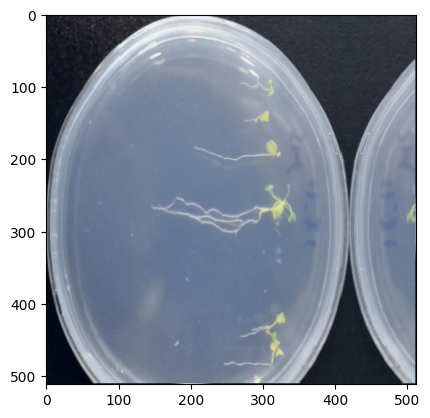

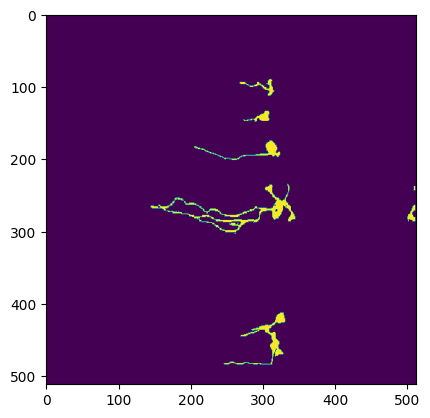

In [36]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

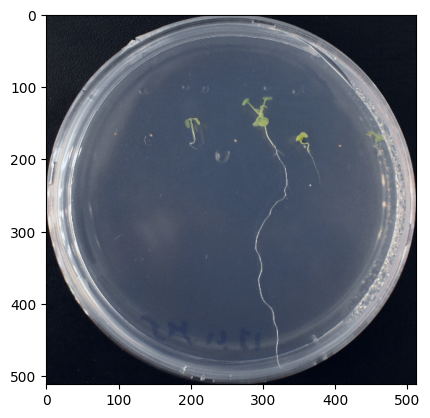

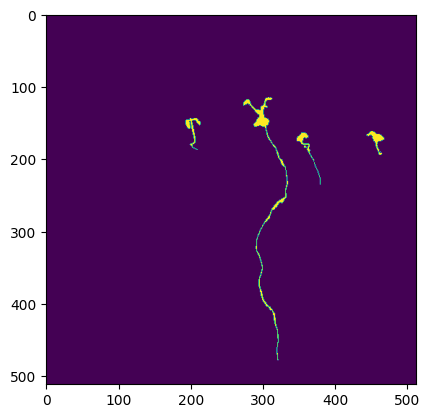

In [21]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [ ]:
#tf.keras.utils.plot_model(model)

In [ ]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 10 and epoch % 10 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=20,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [ ]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1000


KeyboardInterrupt: 

In [ ]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [ ]:
results = model.evaluate(testdata)
results

3/3 [==============================] - 2s 257ms/step - loss: 0.3936 - iou_score: 0.6514


[0.3935815095901489, 0.6514148712158203]

In [ ]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image)
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 124ms/step
